# Alignment of EM sections

This notebook shows how to use SOFIMA to elastically align ultrathin sections of brain tissue acquired with an electron microscope. We will be using a 5000x5000x200 subset of a SBEM dataset of zebrafish brain acquired in Rainer Friedrich's lab at the FMI. You can browse the [unaligned data](https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22x%22:%5B1.1e-8%2C%22m%22%5D%2C%22y%22:%5B1.1e-8%2C%22m%22%5D%2C%22z%22:%5B2.5e-8%2C%22m%22%5D%7D%2C%22position%22:%5B2359.354248046875%2C2653.44775390625%2C99.5%5D%2C%22crossSectionScale%22:3.5180938094527145%2C%22projectionScale%22:8192%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250%22%2C%22tab%22:%22source%22%2C%22name%22:%22subvol_5800_5500_6250%22%7D%5D%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22subvol_5800_5500_6250%22%7D%2C%22layout%22:%224panel%22%7D) in Neuroglancer.

In [ ]:
!pip install tensorstore
import tensorstore as ts

In [2]:
unaligned_1x = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': 'gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250',
    "scale_metadata": {"resolution": [11, 11, 25]},
    "context": { "cache_pool": {"total_bytes_limit": 1_000_000_000},}
    }).result()

In [3]:
# Precomputed volume, 2x downsampled resolution. Downsampling was done with area averaging.
unaligned_2x = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': 'gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250',
    "scale_metadata": {"resolution": [22, 22, 25]},
    "context": { "cache_pool": {"total_bytes_limit": 1_000_000_000},}
    }).result()

In [4]:
unaligned_1x.shape

(5000, 5000, 200, 1)

In [ ]:
!pip install git+https://github.com/google-research/sofima

In [6]:
from concurrent import futures
import time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from connectomics.common import bounding_box
from sofima import flow_field
from sofima import flow_utils
from sofima import map_utils
from sofima import mesh
from sofima import warp
from tqdm.notebook import tqdm

In [7]:
# Ensure that we're running this code on a GPU machine. If this fails and you're using
# Google Colab, use "Edit >> Notebook settings" and set s"Hardware accelerator" to "GPU".
assert jax.devices()[0].platform == 'gpu'

# Flow field estimation

First, we calculate the flow fields between the current section and the directly preceding section. Flow fields can also be computed between pairs of sections that are not directly adjacent. This is useful if sections are incomplete or missing, but is not something we have to worry about in this demo.

In a distributed environment, this step would be done with the `EstimateFlow` processor.


On a V100, the expected time for the flow calculation over a single 5000x5000 section with the settings below, is ~0.6s. The patch (160) and step (40) sizes are set to conservative values which work for most synaptic-resolution EM volumes (i.e. at an in-plane resolution of ~10 nm/px).


In [8]:
# Both of the settings below are expressed in pixels.
patch_size = 160  # XY spatial context used for flow field estimation
stride = 40  # XY distance between centers of adjacent patches.

def _compute_flow(volume):
  mfc = flow_field.JAXMaskedXCorrWithStatsCalculator()
  flows = []
  prev = volume[..., 0, 0].T.read().result()

  fs = []
  with futures.ThreadPoolExecutor() as tpe:
    # Prefetch the next sections to memory so that we don't have to wait for them
    # to load when the GPU becomes available.
    for z in range(1, unaligned_1x.shape[2]):
      fs.append(tpe.submit(lambda z=z: volume[..., z, 0].T.read().result()))
  
    fs = fs[::-1]

    for z in tqdm(range(1, unaligned_1x.shape[2])):
      curr = fs.pop().result()

      # The batch size is a parameter which impacts the efficiency of the computation (but
      # not its result). It has to be large enough for the computation to fully utilize the
      # available GPU capacity, but small enough so that the batch fits in GPU RAM.
      flows.append(mfc.flow_field(prev, curr, (patch_size, patch_size),
                                  (stride, stride), batch_size=256))
      prev = curr

  return flows

Compute flows at native and 2x reduced in-plane resolution. The lower resolution flow has reduced precision, but is helpful for providing approximate flow vectors in places where the full-resolution flow might be impossible to estimate, e.g. in the interior of cell bodies or blood vessels.


In [9]:
flows1x = np.array(_compute_flow(unaligned_1x))
flows2x = np.array(_compute_flow(unaligned_2x))

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

The flow fields generated in the previous step are 4-channel arrays, where the first two channels store the XY components of the flow vector, and the two remaining channels are measures of estimation quality (see `sofima.flow_field._batched_peaks` for more info).

In [10]:
# Convert to [channels, z, y, x].
flows2x = np.transpose(flows2x, [1, 0, 2, 3])
flows1x = np.transpose(flows1x, [1, 0, 2, 3])

# Pad to account for the edges of the images where there is insufficient context to estimate flow.
pad = patch_size // 2 // stride
flows1x = np.pad(flows1x, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)
flows2x = np.pad(flows2x, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)

We now remove uncertain flow estimates by replacing them with NaNs, and merge the two flow arrays into a single flow field at full resolution. In a distributed environment, this step would be done with the `ReconcileAndFilterFlows` processor.

In [11]:
f1 = flow_utils.clean_flow(flows1x, min_peak_ratio=1.6, min_peak_sharpness=1.6, max_magnitude=80, max_deviation=20)
f2 = flow_utils.clean_flow(flows2x, min_peak_ratio=1.6, min_peak_sharpness=1.6, max_magnitude=80, max_deviation=20)

Plot the horizontal component of the flow vector, before (left) and after (right) filtering. While blobs indicate areas where uncertain flow estimates were removed.

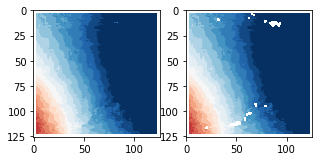

In [25]:
f, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].imshow(flows1x[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[1].imshow(f1[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)

In [13]:
from scipy import interpolate
f2_hires = np.zeros_like(f1)

scale = 0.5
oy, ox = np.ogrid[:f2.shape[-2], :f2.shape[-1]]
oy = oy.ravel() / scale
ox = ox.ravel() / scale

box1x = bounding_box.BoundingBox(start=(0, 0, 0), size=(f1.shape[-1], f1.shape[-2], 1))
box2x = bounding_box.BoundingBox(start=(0, 0, 0), size=(f2.shape[-1], f2.shape[-2], 1))

for z in tqdm(range(f2.shape[1])):
  # Upsample and scale spatial components.
  resampled = map_utils.resample_map(
      f2[:, z:z + 1, ...],  #
      box2x, box1x, 1 / scale, 1)
  f2_hires[:, z:z + 1, ...] = resampled / scale

  0%|          | 0/199 [00:00<?, ?it/s]

In [16]:
final_flow = flow_utils.reconcile_flows((f1, f2_hires), max_gradient=0, max_deviation=20, min_patch_size=400)

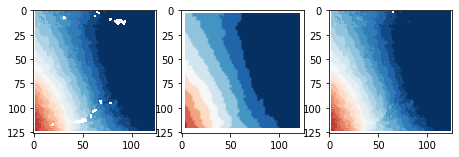

In [26]:
# Plot (left to right): high res. flow, upsampled low res. flow, combined flow to use for alignment.
f, ax = plt.subplots(1, 3, figsize=(7.5, 2.5))
ax[0].imshow(f1[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[1].imshow(f2_hires[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[2].imshow(final_flow[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)

# Mesh optimization

We use an elastic mesh optimizer to find a configuration of the imagery that is compatible with the estimated flow field and preserves the original geometry as much as possible.

The optimization proceeds sequentially, section by section. In a distributed environment, this computation can be parallelized across the plane (by independently solving overlapping XY tiles), as well as split into blocks along the Z axis. This makes it possible to scale this process to arbitrarily large volumes. For simplicity, here we solve the complete stack in one go.

In [18]:
config = mesh.IntegrationConfig(dt=0.001, gamma=0.0, k0=0.01, k=0.1, stride=stride, num_iters=1000,
                                max_iters=100000, stop_v_max=0.005, dt_max=1000, start_cap=0.01,
                                final_cap=10, prefer_orig_order=True)

In [19]:
solved = [np.zeros_like(final_flow[:, 0:1, ...])]
origin = jnp.array([0., 0.])

for z in tqdm(range(0, final_flow.shape[1])):
  prev = map_utils.compose_maps_fast(final_flow[:, z:z+1, ...], origin, stride,
                                     solved[-1], origin, stride)
  x = np.zeros_like(solved[0])
  x, e_kin, num_steps = mesh.relax_mesh(x, prev, config)
  x = np.array(x)
  solved.append(x)

  0%|          | 0/199 [00:00<?, ?it/s]

In [20]:
solved = np.concatenate(solved, axis=1)

# Image warping

Image warping requires an inverse coordinate map, so compute that first. In a distributed environment, this can be done with the `InvertMap` processor.

In [21]:
inv_map = map_utils.invert_map(solved, box1x, box1x, stride)

We are now ready to render the aligned subvolume. To reduce RAM usage, we render a 1000x1000 part for all 200 sections.

In a distributed environment, this can be done with the `WarpByMap` processor.

In [22]:
warped = [np.transpose(unaligned_1x[1000:2000, 2000:3000, 0:1, 0].read().result(), [2, 1, 0])]

for z in tqdm(range(1, unaligned_1x.shape[2])):
  data_box = bounding_box.BoundingBox(start=(500, 1500, 0), size=(2000, 2000, 1))
  out_box = bounding_box.BoundingBox(start=(1000, 2000, 0), size=(1000, 1000, 1))

  data = np.transpose(unaligned_1x[data_box.start[0]:data_box.end[0],
                                   data_box.start[1]:data_box.end[1],
                                   z:z+1, 0:1].read().result(), [3, 2, 1, 0])
  warped.append(
      warp.warp_subvolume(data, data_box, inv_map[:, z:z+1, ...], box1x, stride, out_box, 'lanczos', parallelism=1)[0, ...])

  0%|          | 0/199 [00:00<?, ?it/s]

In [23]:
warped_xyz = np.transpose(np.concatenate(warped, axis=0), [2, 1, 0])

Render an XZ cross section to check the quality of the alignment visually.

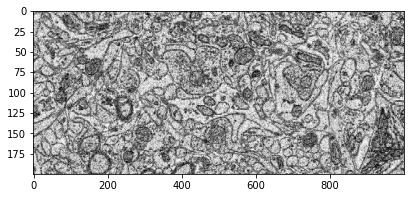

In [28]:
plt.figure(figsize=(7, 3))
plt.imshow(warped_xyz[:, 500, :].T, cmap=plt.cm.Greys_r, aspect=(1000 * 11) / (200 * 25))

The results can be inspected interactively in Neuroglancer as well.

In [ ]:
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y', 'z'], units='nm', scales=[11, 11, 25])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(warped_xyz, dimensions))

viewer